# Comparing two distributions 

In [55]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')
#sns.set_palette("tab10")

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [56]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [57]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## Generate contrived data

In [58]:
mu_real = np.array([90, 100])
sd_real = np.array([10, 3])

n_samples = np.array([100, 100])
factor_levels = np.array(['Manual', 'ACC'])

In [59]:
# Random seed need to be in the same cell.
np.random.seed(SEED)

data = pd.DataFrame(data={
    'speed':np.concatenate(
        [np.random.normal(loc=mu_real[i], scale=sd_real[i], size=n_samples[i]) for i, _ in enumerate(factor_levels)]
    ), 
    'driving_mode':np.repeat(factor_levels, n_samples)
                          })
         
data.driving_mode = pd.Categorical(data.driving_mode, categories=['Manual', 'ACC'], ordered=False)
data.head()

,speed,driving_mode
0,99.259215,Manual
1,63.437963,Manual
2,95.912173,Manual
3,95.210851,Manual
4,106.657916,Manual


In [60]:
data.groupby('driving_mode').agg(['mean', 'std'])

speed           
                    mean        std
driving_mode                       
Manual         90.125569  10.675811
ACC           100.121771   2.933147

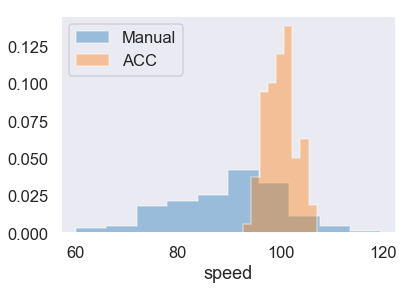

In [61]:
for cat in data.driving_mode.cat.categories:
    sns.distplot(data[data.driving_mode==cat].speed, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled'})

plt.legend();

## Bayesian modelling

In [62]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [63]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=data['speed'].mean(), sd=50, shape=2)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50, shape=2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu[data['driving_mode'].cat.codes.values], 
                                         sd=sd[data['driving_mode'].cat.codes.values], observed=data['speed'].values)
    
    delta_mu = pm.Deterministic('delta_mu', mu[1]-mu[0])
    delta_sd = pm.Deterministic('delta_sd', sd[1]-sd[0])

In [10]:
model.check_test_point()

mu             -9.66
sd_log__       -1.54
likelihood   -926.42
Name: Log-probability of test_point, dtype: float64

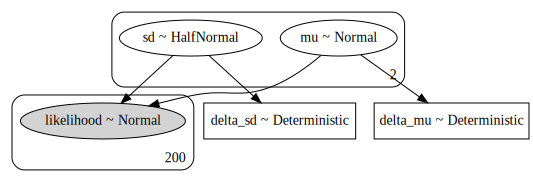

In [11]:
pm.model_to_graphviz(model)

### Sample from the model

In [12]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████████████████████████████████| 12000/12000 [00:11<00:00, 1079.47draws/s]


### Diagnose the sampling

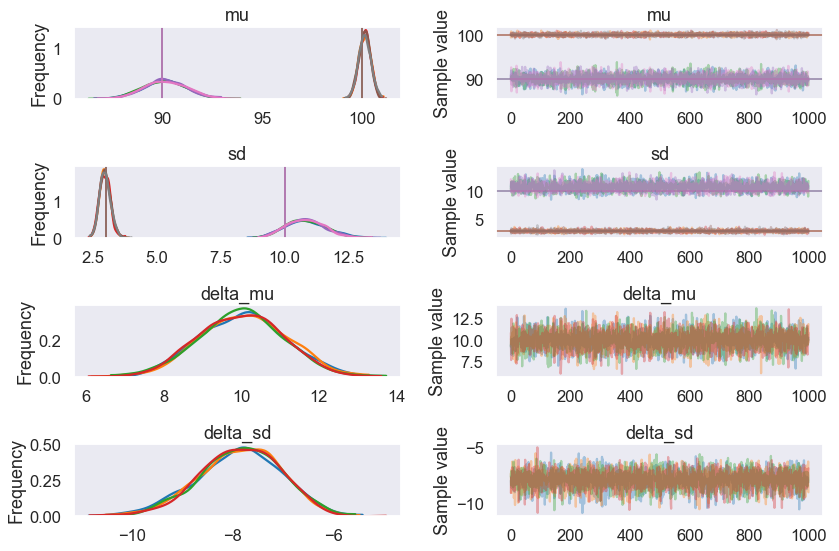

In [64]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

### Summarize the posterior density

In [14]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,90.11,1.07,0.01,88.02,92.16,6257.67,1.0
mu__1,100.12,0.30,0.00,99.56,100.71,5903.96,1.0
sd__0,10.83,0.78,0.01,9.40,12.37,5935.66,1.0
sd__1,2.97,0.22,0.00,2.57,3.41,5819.99,1.0
delta_mu,10.01,1.11,0.01,7.95,12.21,6396.84,1.0
delta_sd,-7.86,0.81,0.01,-9.57,-6.44,5935.78,1.0


### Posterior predictive check

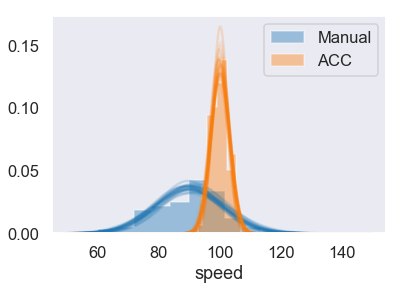

In [65]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(50, 150, 0.5)

for cat in data.driving_mode.cat.categories:
    sns.distplot(data[data.driving_mode==cat].speed, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled'})

for i, group in enumerate(data['driving_mode'].cat.categories): 
    for mu, sd in zip(trace['mu'][::THIN, i], trace['sd'][::THIN, i]):
        ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[i])

plt.legend();

## Statistical inference

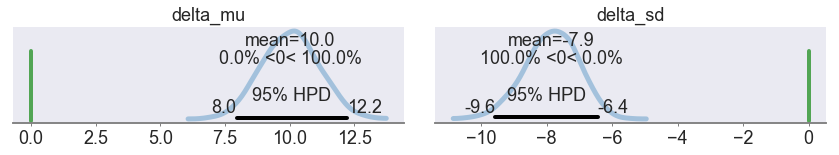

In [66]:
pm.plot_posterior(trace, varnames=['delta_mu', 'delta_sd'], ref_val=0, round_to=1, kde_plot=True, lw=5);